In [134]:
import prey_capture_python as preycap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import signal
from typing import List, Union

In [135]:
file='/Volumes/molly/2022-02-24_9-49-09_mouse-0898/Sky_mouse-0898_2022-02-24T09_49_09DLC_dlcrnetms5_optopreycapFeb16shuffle1_150000_el_filtered.csv'

In [137]:
dfall=pd.read_csv(file, skiprows=[0,1], header=[0,1])
dfall

bodyparts      nose                         Rear                      \
        coords         x        y likelihood        x        y likelihood   
0            0  1012.347  222.142      1.000  980.371  211.307        1.0   
1            1  1015.860  223.590      1.000  982.222  213.921        1.0   
2            2  1021.023  224.109      1.000  984.340  216.514        1.0   
3            3  1024.107  227.707      1.000  989.644  216.514        1.0   
4            4  1024.107  229.986      1.000  990.337  219.137        1.0   
...        ...       ...      ...        ...      ...      ...        ...   
6648      6648   716.911  996.009      0.376  684.706  998.964        1.0   
6649      6649   716.700  996.009      0.289  685.030  998.926        1.0   
6650      6650   716.700  996.031      0.487  685.583  998.926        1.0   
6651      6651   716.616  996.031      0.219  685.583  998.717        1.0   
6652      6652   716.601  995.984      0.465  685.583  998.483        1.0   

          Lear                      ...      spine tailbase           \
             x        y likelihood  ... likelihood        x        y   
0      996.793  186.512        1.0  ...        1.0  900.138  145.522   
1     1003.157  187.092        1.0  ...        1.0  902.559  146.298   
2     1005.944  187.953        1.0  ...        1.0  907.357  147.162   
3     1008.993  190.084        1.0  ...        1.0  907.607  148.338   
4     1009.936  191.243        1.0  ...        1.0  909.119  152.209   
...        ...      ...        ...  ...        ...      ...      ...   
6648   700.389  974.658        1.0  ...        1.0  631.955  960.903   
6649   700.479  974.658        1.0  ...        1.0  632.118  960.959   
6650   700.479  974.592        1.0  ...        1.0  631.955  960.959   
6651   700.389  974.499        1.0  ...        1.0  631.943  960.959   
6652   699.955  973.937        1.0  ...        1.0  631.943  960.959   

                anteriorC                posteriorC                 
     likelihood         x   y likelihood          x   y likelihood  
0           1.0       NaN NaN        NaN        NaN NaN        NaN  
1           1.0       NaN NaN        NaN        NaN NaN        NaN  
2           1.0       NaN NaN        NaN        NaN NaN        NaN  
3           1.0       NaN NaN        NaN        NaN NaN        NaN  
4           1.0       NaN NaN        NaN        NaN NaN        NaN  
...         ...       ...  ..        ...        ...  ..        ...  
6648        1.0       NaN NaN        NaN        NaN NaN        NaN  
6649        1.0       NaN NaN        NaN        NaN NaN        NaN  
6650        1.0       NaN NaN        NaN        NaN NaN        NaN  
6651        1.0       NaN NaN        NaN        NaN NaN        NaN  
6652        1.0       NaN NaN        NaN        NaN NaN        NaN  

[6653 rows x 25 columns]

In [138]:
bodyparts=['anteriorC', 'posteriorC']
data=pd.read_csv(file, skiprows=[0,1], header=[0,1])
data=data.loc[:, bodyparts]

In [139]:
data

anteriorC                posteriorC               
             x   y likelihood          x   y likelihood
0          NaN NaN        NaN        NaN NaN        NaN
1          NaN NaN        NaN        NaN NaN        NaN
2          NaN NaN        NaN        NaN NaN        NaN
3          NaN NaN        NaN        NaN NaN        NaN
4          NaN NaN        NaN        NaN NaN        NaN
...        ...  ..        ...        ...  ..        ...
6648       NaN NaN        NaN        NaN NaN        NaN
6649       NaN NaN        NaN        NaN NaN        NaN
6650       NaN NaN        NaN        NaN NaN        NaN
6651       NaN NaN        NaN        NaN NaN        NaN
6652       NaN NaN        NaN        NaN NaN        NaN

[6653 rows x 6 columns]

In [148]:
test=data['anteriorC']
test

,x,y,likelihood
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
6648,NaN,NaN,NaN
6649,NaN,NaN,NaN
6650,NaN,NaN,NaN
6651,NaN,NaN,NaN


In [79]:
def relentless_positivity(df: pd.DataFrame, column:str, window: int = 20, threshold: float = 0.95,tolist:bool = True) -> Union[List[List[int]], np.ndarray]:
    """
    Find ranges where column is above threshold for #window number of rows

    Returns:
        List of Lists indicating the start and end of positive ranges
    """
    inds=np.where(df[column].rolling(window).sum()>=threshold*window)[0]
    starts=inds[np.diff(inds, prepend=-1)!=1]-window+1
    ends=inds[np.diff(inds, append=-1)!=1]
    periods=np.column_stack([starts, ends])
    start=np.min(periods)
    # print(start)
    end=np.max(periods)
    # print(end)
    if tolist:
        return periods.tolist(), start, end
    else:
        return periods, start, end

In [116]:
threshold=0.95
front_p=np.asarray(data['anteriorC', 'likelihood'])
back_p=np.asarray(data['posteriorC', 'likelihood'])

frontx=np.asarray(data['anteriorC', 'x'])
backx=np.asarray(data['posteriorC', 'x'])

fronty=np.asarray(data['anteriorC', 'y'])
backy=np.asarray(data['posteriorC', 'y'])

cricket=np.where(np.logical_and(front_p>threshold, back_p>threshold))[0]

front_x= np.take(frontx,cricket)
back_x=np.take(backx, cricket)

front_y= np.take(fronty,cricket)
back_y=np.take(backy, cricket)

front_xy=np.asarray([front_x, front_y])
back_xy=np.asarray([back_x, back_y])

In [133]:
cricket

array([ 614,  615, 1763, ..., 4591, 4592, 4593])

In [70]:
xlength=np.abs(front_x-back_x)
ylength=np.abs(front_y-back_y)

In [66]:
ylength/15.8


1.0279882874727542

In [117]:
df=pd.DataFrame(columns=['xlength','ylength','front_x','back_x', 'front_y','back_y', 'distance' ])

In [129]:
df['xlength']=xlength/15.8
df['ylength']=ylength/15.8
df['front_x']=front_x/15.8
df['back_x']=back_x/15.8
df['front_y']=front_y/15.8
df['back_y']=back_y/15.8
df['distance']=dist/15.8

In [130]:
df

,xlength,ylength,front_x,back_x,front_y,back_y,distance
0,0.073987,0.709241,71.117785,71.191772,21.902278,22.611519,0.713089
1,0.081962,0.709241,71.109810,71.191772,21.902278,22.611519,0.713961
2,NaN,NaN,NaN,NaN,NaN,NaN,0.817395
3,0.920506,0.024367,25.518228,24.597722,24.675823,24.651456,0.920829
4,0.920506,0.024367,25.518228,24.597722,24.675823,24.651456,0.920829
...,...,...,...,...,...,...,...
2499,0.136266,0.336772,31.895316,31.759051,47.874810,48.211582,0.363296
2500,0.104810,0.344051,31.895316,31.790506,47.837785,48.181835,0.359661
2501,0.104810,0.325949,31.895316,31.790506,47.837785,48.163734,0.342386
2502,0.120696,0.379241,31.911203,31.790506,47.755506,48.134747,0.397984


In [132]:
df.isna().sum()

xlength     1
ylength     1
front_x     1
back_x      1
front_y     1
back_y      1
distance    0
dtype: int64

In [131]:
df.mean()

xlength      0.533601
ylength      1.027988
front_x     45.349275
back_x      45.313768
front_y     22.573496
back_y      21.689793
distance     1.276114
dtype: float64

In [98]:
periods, start, end = relentless_positivity(df, 'ylength', window=200,threshold=0.01)

In [99]:
periods

[[3, 2503]]

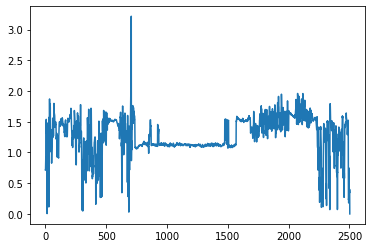

In [150]:
plt.plot(dist/15.8)

In [112]:
diff=np.diff(ylength)

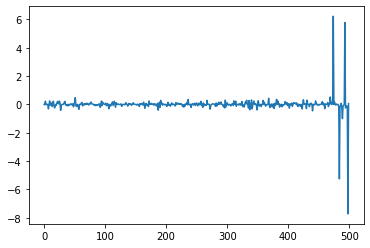

In [114]:
plt.plot(diff[1000:1500])

In [120]:
def distance(xy1, xy2):
    """
    Function used to calculate speeds during the prey capture trial. Can be used
    for either mouse or cricket speeds.
    Arguments:
        xy1 (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        xy2 (:class:`numpy.ndarray`): an n x 2 array of coordinates over time

    Returns:
        dist (:class:`numpy.ndarray`): an array containing distance between two
            objects over time
    """
    dist = np.sqrt(np.square(xy1[0]- xy2[0]) + np.square(xy1[1] - xy2[1]))
    dist[-1]=0 #we can think about if we want this but last point should be the capture, right now forcing capture even if there isnt one
    #interpolate the range values to make up for dropped cricket points
    ind = np.arange(0,len(dist))
    interp = interpolate.interp1d(ind[~np.isnan(dist)], dist[~np.isnan(dist)],bounds_error=False, fill_value=np.nan )
    range_interp = interp(ind)
    dist = range_interp
    return dist

In [121]:
dist=distance(front_xy, back_xy)

In [122]:
dist

array([11.26680953, 11.28057893, 12.91483689, ...,  5.40969833,
        6.28814066,  0.        ])

In [126]:
np.mean(dist)/15.8

1.276113521441184